In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from dataset import DatasetBuilder

In [13]:
dataset_builder = DatasetBuilder('twitter15', only_binary=True, time_cutoff=10000)
full_dataset = dataset_builder.create_dataset(dataset_type="raw", standardize_features=False)

Considering only binary classification problem
We consider tweets emitted no later than 10000mins after the root tweet
Len train/val/test 500 75 167
Oversampling...
Before oversampling: 742 trees, 500 train trees
After oversampling: 742 trees, 500 train trees
Dataset loaded in 14.347s


In [14]:
train_set = full_dataset['train']

In [10]:
def preprocess_graph(graph_raw):
    """
    list of [graph_label, graph_root_id, edge_info = [node_index_in, node_index_out, time_out, uid_in, uid_out]]
    """
    edges = [(elt[2], elt[3]) for elt in graph_raw]
    times = [elt[4] for elt in graph_raw]
    label = graph_raw[0][0]
    graph_id = graph_raw[0][1]
    return label, graph_id, edges, times

In [7]:
def preprocessed_to_nx(label, gid, edges, times, first_n=None, time_cutoff=None):
    assert time_cutoff is None or first_n is None
    if time_cutoff is not None:
        edges = [edge for i, edge in enumerate(edges) if times[i]<time_cutoff]
        times = [ts for ts in times if ts<time_cutoff]
    if first_n is not None:
        edges = edges[:first_n]
        times = times[:first_n]
    nx_graph = nx.DiGraph()
    edges_list = [(edge[0], edge[1], {"ts":times[i]}) for i, edge in enumerate(edges)]
    nx_graph.add_edges_from(edges_list)
    return nx_graph

In [8]:
from collections import defaultdict
from tqdm import tqdm

In [82]:
times_seq = defaultdict(lambda : [])
for dp in tqdm(train_set):
    if not len(dp):
        continue
    lab, gid, edges_l, times_l = preprocess_graph(dp)
    graph = preprocessed_to_nx(lab, gid, edges_l, times_l)
    for edge in graph.edges(data=True):
        times_seq[lab].append(edge[2]['ts'])

100%|██████████| 500/500 [00:00<00:00, 1432.11it/s]


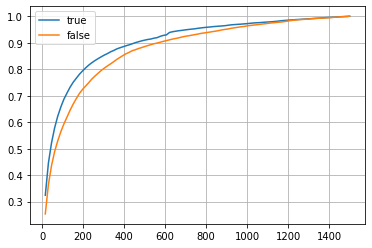

In [105]:
for lab, times in times_seq.items():
    times_arr = np.array(times)
    x_vals = np.linspace(0., 1500., num=100)
    results = np.zeros(x_vals.shape[0]-1)
    total = len(times_arr)
    for i in range(len(results)):
        results[i] = len(times_arr[times_arr<x_vals[i+1]])/total
    plt.plot(x_vals[1:], results, label=lab)
#     plt.hist(times_arr)
    plt.legend()
plt.grid()
plt.show()

plt.close()

In [83]:
len(graph)

116

In [84]:
graph.size()

115

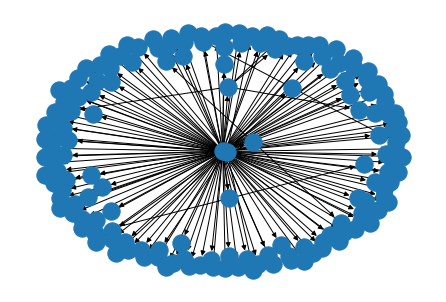

In [69]:
nx.draw(graph)

In [72]:
def engagement(data_point, time_lim):
    labl, graph_id, edges, times = preprocess_graph(data_point)
    number = 0
    n = len(times)
    ids_set = {edges[0][0]}
    numbers = np.zeros(n, dtype=float)
    times = np.array(times)
    for i in range(n):
        node_out = edges[i][1]
        if node_out not in ids_set:
            ids_set.add(node_out)
            number += 1
        numbers[i] = number
    indexer = times < time_lim
    return times[indexer], numbers[indexer]


def plot_engagement(index, time_lim=120):
    graph = train_set[index]
    xs, ys = engagement(graph, time_lim)
    plt.plot(xs, ys, color='black')
    plt.grid()
    plt.xlabel(f"Time in minutes from root tweet to {time_lim}")
    plt.ylabel(f"#Retweets, story label is {labl.upper()}")
    return xs, ys


In [73]:
index = 16
time_lim = 120

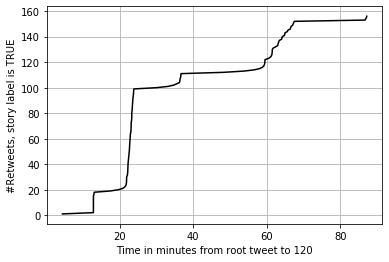

In [136]:
xc, yc = plot_engagement(index, time_lim)

### Fitting a SEIZ model to tweets

In [137]:
#Parameters
# β S-I contact rate
# b S-Z contact rate
# ρ E-I contact rate
# epsilon Incubation rate
# 1/epsilon Average Incubation Time
# bl Effective rate of S -> Z
# βρ Effective rate of S -> I
# b(1-l) Effective rate of S -> E via contact with Z
# β(1 − p) Effective rate of S -> E via contact with I
# l S->Z Probability given contact with skeptics
# 1-l S->E Probability given contact with skeptics
# p S->I Probability given contact with adopters
# 1-p S->E Probability given contact with adopters
# S_0, E_0, I_0, Z_0, N_0 initial compartments sizes

#Optimization parameters: starting point and bounds
x_0 = np.array([0.4, 0.2, 0.3, 0.1, 0.5, 0.55, 100, 200, 1, 99])
my_bounds = (0.,[1., 1., 1. , 1., 1., 1., 1e8, 1e8, 1e8, 1e8])

In [138]:
def solve_seiz_ode(x0, jac_seiz, num_steps=100, max_time=120.):
    timestep = max_time / (num_steps-1) # note that the number of points returned is num_steps + 1
    values = np.zeros((num_steps, 4), dtype=float)
    seiz = np.copy(x0[-4:])
    params = np.copy(x0[:6])
    values[0, :] = seiz
    for step in range(num_steps-1):
        seiz += timestep * jac_seiz(seiz, params)
        values[step+1, :] = seiz
    return values, np.linspace(0., max_time, num_steps)

In [139]:
def seiz_func(seiz, params):
    """
    params of the form:
    beta, b, rho, epsilon, l, p 
    """
    s, e, i, z = seiz
    beta, b, rho, epsilon, l, p = params
    n = seiz.sum()
    ds = - beta * s * i / n - b * s * z / n
    de = (1 - p) * beta * s * i / n + (1 - l) * b * s * z / n - rho * e * i / n - epsilon * e 
    di = p * beta * s * i / n + rho * e * i / n + epsilon * e
    dz = l * b * s * z / n
    return np.array([ds, de, di, dz])

In [140]:
from functools import partial
from scipy.optimize import least_squares

In [141]:
def cost_function_tweets(parameters, target_values, target_times, num_euler_steps, max_time):
    fitted_values, time_points = solve_seiz_ode(parameters, seiz_func, num_euler_steps, max_time)
    fitted_values = np.interp(target_times, time_points, fitted_values[:, 2])
    return fitted_values - target_values

In [156]:
train_set[16][0][0]

'false'

In [161]:
def seiz_fit(datapoint, time_lim=120., euler_steps=200, fitting_points=100):
    xc, yc = engagement(datapoint, time_lim)
    times = np.linspace(0., time_lim, num=fitting_points)
    retweets_over_time = np.interp(times, xc, yc)
    cost_func = partial(cost_function_tweets, target_values=retweets_over_time, target_times=times, num_euler_steps=euler_steps, max_time=time_lim)
    optimal_result = least_squares(cost_func, x0=x_0, bounds=my_bounds, method='trf', loss='linear', verbose=0, max_nfev=50)
    opt_params = optimal_result.x
#     final_fitted_values = cost_func(opt_params) + retweets_over_time
#     plt.plot(times, final_fitted_values, color='red')
#     plt.plot(times, retweets_over_time, color='black')
#     plt.grid()
    beta, b, rho, epsilon, l, p = opt_params[:6]
    r_score = ((1 - p) * beta + (1 - l) * b) / (rho + epsilon)
    return r_score

In [162]:
seiz_fit(train_set[16])

0.9997626573754672

In [182]:
y_vals = []
r_vals = []
for dp in tqdm(train_set):
    if len(dp):
        label_val = 0. if dp[0][0] == 'false' else 1.
        try:
            r_val = seiz_fit(dp)
            y_vals.append(label_val)
            r_vals.append(r_val)
        except ValueError:
            pass




  0%|          | 0/500 [00:00<?, ?it/s]


  0%|          | 1/500 [00:01<13:26,  1.62s/it]


  0%|          | 2/500 [00:03<12:56,  1.56s/it]


  1%|          | 3/500 [00:03<10:42,  1.29s/it]


  1%|          | 4/500 [00:05<11:04,  1.34s/it]


  1%|          | 5/500 [00:06<11:27,  1.39s/it]


  1%|          | 6/500 [00:08<11:56,  1.45s/it]


  1%|▏         | 7/500 [00:10<12:41,  1.54s/it]


  2%|▏         | 8/500 [00:11<12:43,  1.55s/it]


  2%|▏         | 9/500 [00:13<12:22,  1.51s/it]


  2%|▏         | 10/500 [00:13<10:20,  1.27s/it]


  2%|▏         | 11/500 [00:14<09:02,  1.11s/it]


  2%|▏         | 12/500 [00:16<10:53,  1.34s/it]


  3%|▎         | 13/500 [00:17<09:58,  1.23s/it]


  3%|▎         | 14/500 [00:17<08:01,  1.01it/s]


  3%|▎         | 15/500 [00:18<06:49,  1.18it/s]


  3%|▎         | 16/500 [00:19<08:35,  1.06s/it]


  3%|▎         | 17/500 [00:21<09:32,  1.19s/it]


  4%|▎         | 18/500 [00:22<10:41,  1.33s/it]


  4%|▍         | 19/500 [00:24<11:07,  1.39s/i

In [183]:
def plot_bin_means_and_sizes(ax, plt_type, bins, means, sizes, feat_name="r score", labels_min=0., labels_max=1.0):
    ax[0].plot(bins, means, color='black')
    ax[0].grid()
    ax[0].set_xlabel(feat_name)
    ax[0].set_ylabel('label')
    ax[0].set_ylim(labels_min, labels_max)
    ax[1].bar(np.arange(sizes.shape[0]) if plt_type == "numerical" else bins, sizes, color='blue')
    ax[1].grid()
    if plt_type == "numerical":
        ax[1].set_xlabel("Bin number")
    else:
        ax[1].set_xlabel("Categories")
        ax[1].set_xticks(bins)
        ax[0].set_xticks(bins)
    ax[1].set_ylabel("Bin size")

In [200]:
def numerical_binned_plot(feature_vals, labels, min_qt=0.01, max_qt=0.99, nbins=11):
    quantiles = np.linspace(min_qt, max_qt, num=nbins)
    bin_edges = np.quantile(feature_vals, quantiles)
    bin_size, _ = np.histogram(feature_vals, bins=bin_edges)
    ft_sum, _ = np.histogram(feature_vals, bins=bin_edges, weights=feature_vals)
    labels_sum, _ = np.histogram(feature_vals, bins=bin_edges, weights=labels)
    ft_sum = ft_sum[bin_size > 0]
    labels_sum = labels_sum[bin_size > 0]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    plot_bin_means_and_sizes(ax=ax, bins=ft_sum / bin_size[bin_size > 0], means=labels_sum / bin_size[bin_size > 0],
                             sizes=bin_size, plt_type="numerical")

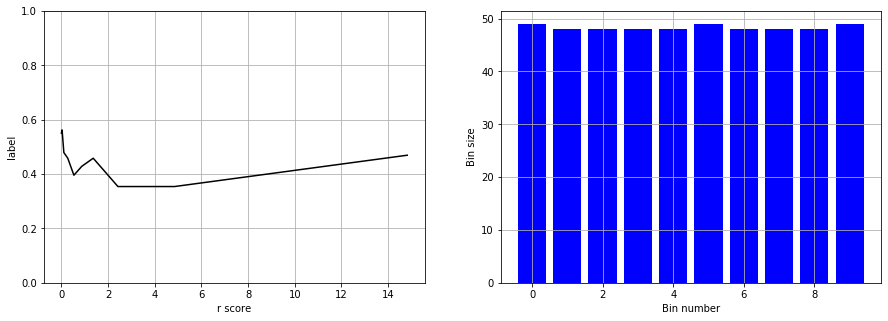

In [202]:
numerical_binned_plot(np.array(r_vals), np.array(y_vals))